In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import uniform, randint

# Data Preprocessing (same as before)
data_dir = "C:\\Users\\Aneesh PB\\Downloads\\Topology Project\\Full segment\\Entropy\\"
classes = ['Normal cases', 'Bengin cases', 'Malignant cases']
X = []
y = []

max_length = 0

# First pass to find max_length
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(class_dir, file_name)
            df = pd.read_excel(file_path)
            flattened = df.to_numpy().flatten()
            max_length = max(max_length, len(flattened))

# Second pass: flatten arrays and pad them to max_length
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(class_dir, file_name)
            df = pd.read_excel(file_path)
            flattened = df.to_numpy().flatten()
            padded_features = np.pad(flattened, (0, max_length - len(flattened)), mode='constant')
            X.append(padded_features)
            y.append(class_idx)

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)  # Number of neighbors
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])  # Distance metric
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Weight function
    p = trial.suggest_int('p', 1, 2)  # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)

    # Create the KNN model with the hyperparameters
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights, p=p)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Return the accuracy as the objective to maximize

# Create an Optuna study and optimize the hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=5000)  # Number of trials can be adjusted based on time and computation

# Print the best hyperparameters and corresponding accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Optionally, you can train the model with the best parameters
best_params = study.best_params
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                                metric=best_params['metric'],
                                weights=best_params['weights'],
                                p=best_params['p'])

best_knn.fit(X_train_scaled, y_train)
y_pred_best_knn = best_knn.predict(X_test_scaled)

# Final Evaluation
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"Accuracy with Optimized KNN: {accuracy_best_knn * 100:.2f}%")


[I 2024-11-19 22:13:18,832] A new study created in memory with name: no-name-07ddf826-f9b2-4a36-80c9-26fe241fd849
[I 2024-11-19 22:13:20,346] Trial 0 finished with value: 0.9255813953488372 and parameters: {'n_neighbors': 8, 'metric': 'minkowski', 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9255813953488372.
[I 2024-11-19 22:13:20,549] Trial 1 finished with value: 0.9209302325581395 and parameters: {'n_neighbors': 8, 'metric': 'minkowski', 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9255813953488372.
[I 2024-11-19 22:13:20,899] Trial 2 finished with value: 0.9395348837209302 and parameters: {'n_neighbors': 7, 'metric': 'minkowski', 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.9395348837209302.
[I 2024-11-19 22:13:22,675] Trial 3 finished with value: 0.9209302325581395 and parameters: {'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.9395348837209302.
[I 2024-11-19 22:13:22,880] Trial

Best Hyperparameters: {'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'distance', 'p': 2}
Best Accuracy: 0.9721
Accuracy with Optimized KNN: 97.21%


In [13]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def optimize_random_forest(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Increased range for more flexibility
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)  # Allows fractional values for features
    
    # Additional parameters
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])  # Adds different splitting criteria
    if bootstrap:  # max_samples is only relevant if bootstrap is True
        max_samples = trial.suggest_float("max_samples", 0.5, 1.0)

    # Initialize the model with suggested hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        max_samples=max_samples if bootstrap else None,  # Only applies if bootstrap is True
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation
    scores = cross_val_score(rf_model, X_train, y_train, cv=3, scoring="accuracy")
    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")

study.optimize(optimize_random_forest, n_trials=5000)

# Retrieve the best parameters
best_rf_params = study.best_params
print("Best parameters for Random Forest:", best_rf_params)

# Train the best RandomForest model with these parameters
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=2, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

[I 2024-11-20 18:33:22,916] A new study created in memory with name: no-name-a51c324e-5d66-473c-a3f6-aab4133fcb79
[I 2024-11-20 18:33:34,247] Trial 0 finished with value: 0.9242424242424243 and parameters: {'n_estimators': 482, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.2469138896063875, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9242424242424243.
[I 2024-11-20 18:33:47,026] Trial 1 finished with value: 0.921911421911422 and parameters: {'n_estimators': 426, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.3358797720216663, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.9242424242424243.
[I 2024-11-20 18:33:53,111] Trial 2 finished with value: 0.8857808857808859 and parameters: {'n_estimators': 97, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.7393760599448782, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial

Best parameters for Random Forest: {'n_estimators': 96, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.11494377139413231, 'bootstrap': False, 'criterion': 'log_loss'}


RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=22,
                       max_features=0.11494377139413231, min_samples_split=3,
                       n_estimators=96, n_jobs=-1, random_state=2)

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Function to optimize hyperparameters using Optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'multi:softmax',
        'num_class': len(classes),  # Ensure this is set correctly based on your target variable
        'eval_metric': 'mlogloss'
    }

    # Create the model with the suggested hyperparameters
    model = xgb.XGBClassifier(**param, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = (y_pred == y_test).mean()  # Accuracy as the objective to maximize

    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
study.optimize(objective, n_trials=5000)

# Print the best trial details
print(f"Best trial: {study.best_trial.params}")

# Train the model with the best parameters found
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict and evaluate the final model
y_pred = best_model.predict(X_test)
print("Optuna Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import optuna
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Optuna optimization objective function
def objective(trial):
    # Define the search space for each parameter
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
    if kernel in ['poly', 'rbf', 'sigmoid']:
        gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)
    else:
        gamma = 'scale'  # 'scale' is recommended for linear kernels

    # Only use degree parameter if kernel is 'poly'
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3  # Default value for non-poly kernels

    # Create and train the SVM model
    model = svm.SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set and calculate accuracy
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase `n_trials` for a more thorough search

# Display the best parameters and accuracy
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Train and evaluate an SVM model with the best parameters found
best_params = study.best_params
best_svm = svm.SVC(**best_params)
best_svm.fit(X_train_scaled, y_train)
y_pred_best = best_svm.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Optimized SVM accuracy: {best_accuracy * 100:.2f}%")


In [2]:
best_knn_params= {'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'distance', 'p': 2}

import optuna
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

    # Create the KNN model with the hyperparameters
model = KNeighborsClassifier(**best_knn_params)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)  # Return the accuracy as the objective to maximize

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9720930232558139
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        74
           1       0.81      0.89      0.85        19
           2       1.00      1.00      1.00       122

    accuracy                           0.97       215
   macro avg       0.93      0.95      0.94       215
weighted avg       0.97      0.97      0.97       215

Confusion Matrix:
[[ 70   4   0]
 [  2  17   0]
 [  0   0 122]]


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import xgboost as xgb

best_xgb_params={'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.06885150946934547, 'subsample': 0.6303179111470338, 'colsample_bytree': 0.6849104713336981, 'min_child_weight': 6, 'gamma': 0.05623703053315749, 'reg_alpha': 1.3350794889649398e-06, 'reg_lambda': 0.15009315120985142,'random_state':42}

best_model = xgb.XGBClassifier(**best_xgb_params)
best_model.fit(X_train, y_train)

# Predict and evaluate the final model
y_pred = best_model.predict(X_test)
print("Optuna Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Optuna Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        74
           1       0.90      0.47      0.62        19
           2       0.98      1.00      0.99       122

    accuracy                           0.93       215
   macro avg       0.92      0.81      0.84       215
weighted avg       0.93      0.93      0.93       215

Confusion Matrix:
[[ 70   1   3]
 [ 10   9   0]
 [  0   0 122]]


In [4]:
best_svm_params={'C': 0.7335099554175057, 'kernel': 'poly', 'gamma': 0.08926274795963234, 'degree': 3}

import optuna
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model = svm.SVC(**best_svm_params)
model.fit(X_train, y_train)

# Predict on the test set and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)  # Return the accuracy as the objective to maximize

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9302325581395349
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90        74
           1       0.83      0.53      0.65        19
           2       0.99      0.98      0.98       122

    accuracy                           0.93       215
   macro avg       0.89      0.82      0.84       215
weighted avg       0.93      0.93      0.93       215

Confusion Matrix:
[[ 71   2   1]
 [  9  10   0]
 [  3   0 119]]


In [5]:
from sklearn.ensemble import RandomForestClassifier

best_rf_params={'n_estimators': 96, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.11494377139413231, 'bootstrap': False, 'criterion': 'log_loss','random_state':19}
rf_model = RandomForestClassifier(**best_rf_params)
# Train the model
rf_model.fit(X_train, y_train)

# Test the model
y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:",accuracy)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9720930232558139
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        74
           1       0.93      0.74      0.82        19
           2       1.00      1.00      1.00       122

    accuracy                           0.97       215
   macro avg       0.96      0.91      0.93       215
weighted avg       0.97      0.97      0.97       215

Confusion Matrix:
[[ 73   1   0]
 [  5  14   0]
 [  0   0 122]]


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming best parameters are already defined:
# best_xgb_params, best_rf_params, best_knn_params, best_svm_params

# Define the models with best parameters
models = {
    "XGBoost": XGBClassifier(**best_xgb_params),
    "Random Forest": RandomForestClassifier(**best_rf_params),
    "KNN": KNeighborsClassifier(**best_knn_params),
    "SVM": SVC(probability=True, **best_svm_params)  # Using probability=True for ROC/PR-AUC
}

# Binarize the true labels for PR-AUC and ROC-AUC calculations (required for multiclass)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Dictionary to store metrics for each model
metrics = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Predict probabilities for AUC metrics
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:  # For models like SVM without `predict_proba`, use decision_function
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate PR-AUC and ROC-AUC
    pr_auc = average_precision_score(y_test_binarized, y_pred_proba, average="macro")
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr", average="macro")
    
    # Store metrics for the current model
    metrics[model_name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy,
        "PR-AUC": pr_auc,
        "ROC-AUC": roc_auc
    }

# Print metrics for each model
for model_name, metric_values in metrics.items():
    print(f"\nMetrics for {model_name}:")
    for metric_name, value in metric_values.items():
        print(f"  {metric_name}: {value:.2%}")



Metrics for XGBoost:
  Precision: 93.45%
  Recall: 93.49%
  F1-Score: 92.83%
  Accuracy: 93.49%
  PR-AUC: 92.21%
  ROC-AUC: 98.18%

Metrics for Random Forest:
  Precision: 97.20%
  Recall: 97.21%
  F1-Score: 97.08%
  Accuracy: 97.21%
  PR-AUC: 97.94%
  ROC-AUC: 99.64%

Metrics for KNN:
  Precision: 97.36%
  Recall: 97.21%
  F1-Score: 97.26%
  Accuracy: 97.21%
  PR-AUC: 96.56%
  ROC-AUC: 99.45%

Metrics for SVM:
  Precision: 93.08%
  Recall: 93.02%
  F1-Score: 92.64%
  Accuracy: 93.02%
  PR-AUC: 88.79%
  ROC-AUC: 98.05%


Generating PR-AUC curves for XGBoost...


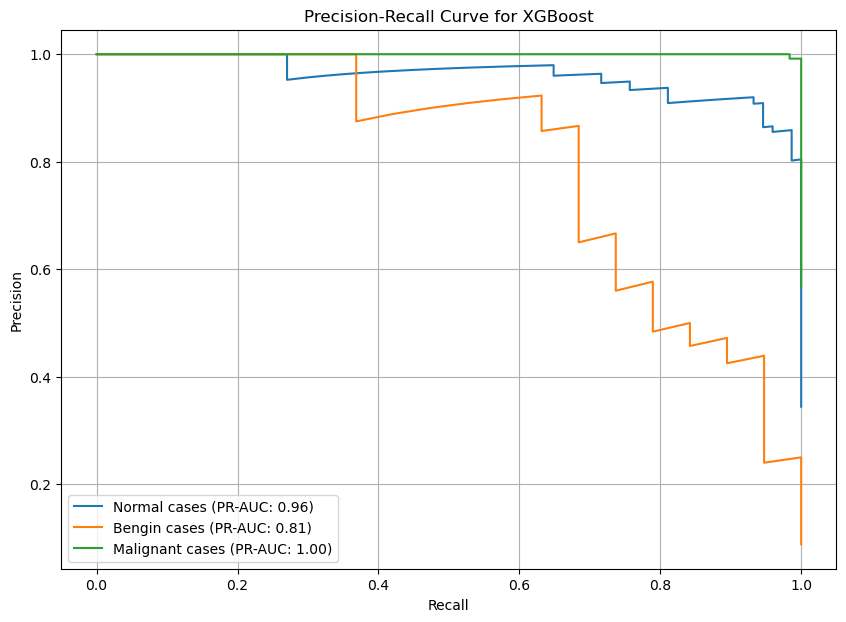

Generating PR-AUC curves for Random Forest...


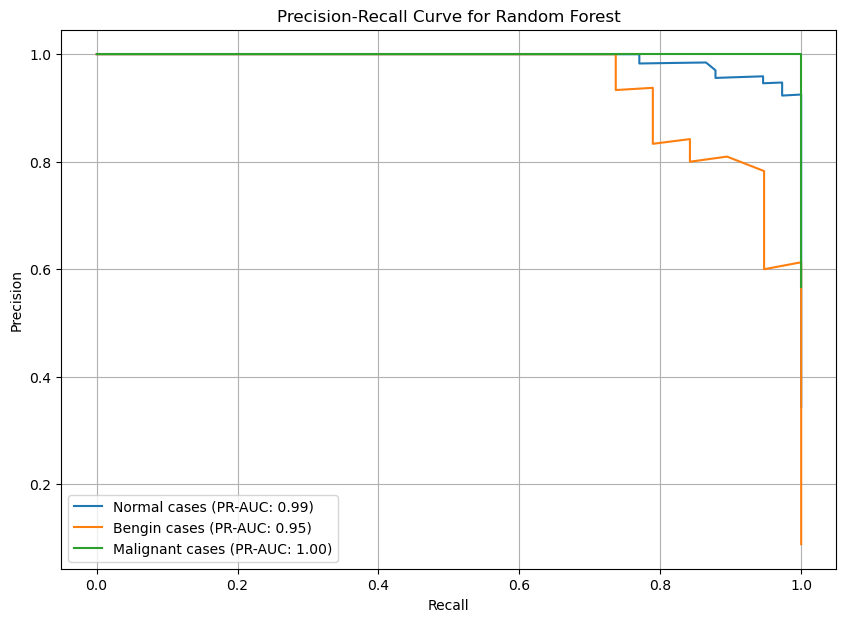

Generating PR-AUC curves for KNN...


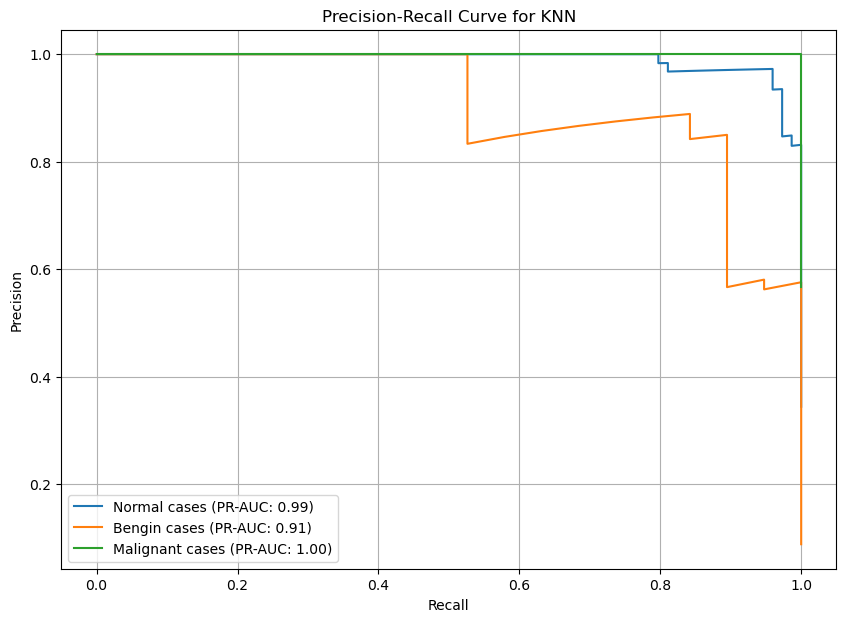

Generating PR-AUC curves for SVM...


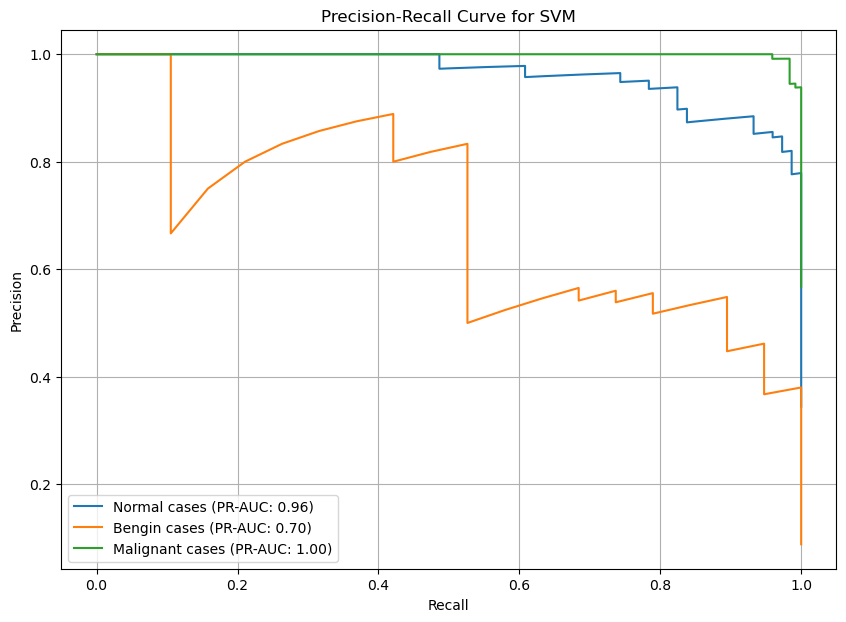

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming the models are defined and trained: models dictionary from the previous step
# Also assuming y_test and y_test_binarized are defined

# Plot PR-AUC for each model
for model_name, model in models.items():
    print(f"Generating PR-AUC curves for {model_name}...")
    
    # Predict probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = model.decision_function(X_test)
    
    plt.figure(figsize=(10, 7))
    
    # Generate Precision-Recall curves for each class
    for i, class_name in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        pr_auc = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, label=f"{class_name} (PR-AUC: {pr_auc:.2f})")
    
    # Plot settings
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


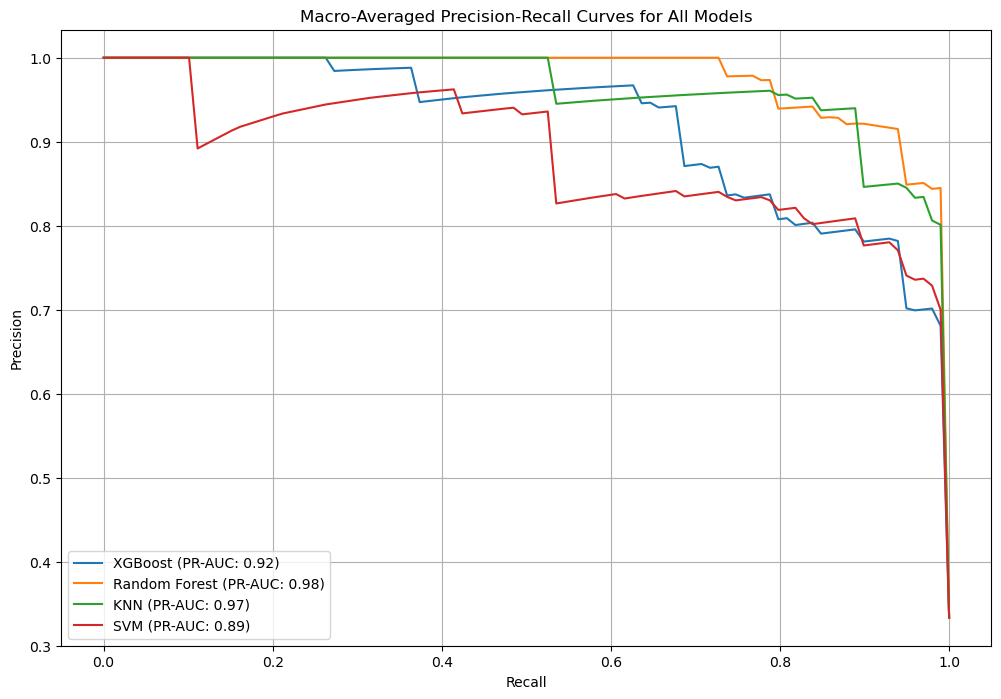

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming the models are defined and trained: models dictionary from the previous step
# Also assuming y_test and y_test_binarized are defined

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot PR-AUC curves for all models
for model_name, model in models.items():
    # Predict probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Initialize variables to calculate macro-average PR curve
    precisions = []
    recalls = []
    auc_scores = []
    
    # Compute PR curve and AUC for each class
    for i in range(y_test_binarized.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        pr_auc = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
        
        # Interpolate to standardize recall points (for averaging)
        recalls_interp = np.linspace(0, 1, 100)
        precisions_interp = np.interp(recalls_interp, recall[::-1], precision[::-1])
        
        precisions.append(precisions_interp)
        auc_scores.append(pr_auc)
    
    # Compute the macro-average precision and recall
    macro_precision = np.mean(precisions, axis=0)
    macro_recall = np.linspace(0, 1, 100)
    macro_auc = np.mean(auc_scores)
    
    # Plot the macro-average PR curve
    plt.plot(macro_recall, macro_precision, label=f"{model_name} (PR-AUC: {macro_auc:.2f})")

# Plot settings
plt.title("Macro-Averaged Precision-Recall Curves for All Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()


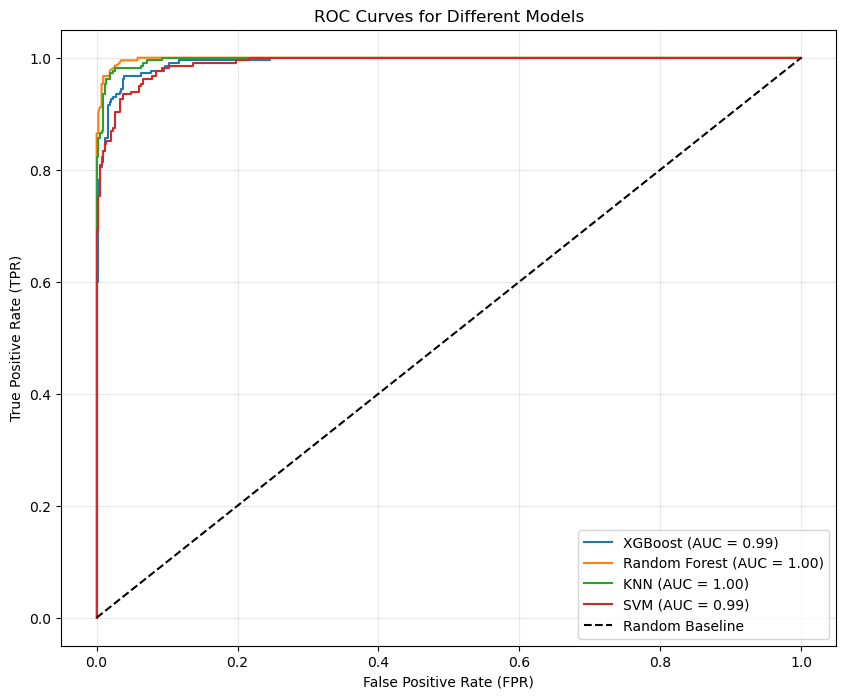

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Split the data into train and test sets

# Binarize labels for ROC computation (needed for multiclass)
y_binarized = label_binarize(y_test, classes=list(range(len(set(y)))))

# Initialize models with the best parameters
xgb_model = XGBClassifier(**best_xgb_params)
rf_model = RandomForestClassifier(**best_rf_params)
knn_model = KNeighborsClassifier(**best_knn_params)
svm_model =SVC(**best_svm_params, probability=True)

# Fit models
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predict probabilities
xgb_probs = xgb_model.predict_proba(X_test)
rf_probs = rf_model.predict_proba(X_test)
knn_probs = knn_model.predict_proba(X_test)
svm_probs = svm_model.predict_proba(X_test)

# Compute ROC curves and AUCs
plt.figure(figsize=(10, 8))

models = [
    ("XGBoost", xgb_probs),
    ("Random Forest", rf_probs),
    ("KNN", knn_probs),
    ("SVM", svm_probs)
]

for model_name, probs in models:
    fpr, tpr, _ = roc_curve(y_binarized.ravel(), probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

# Add labels and legend
plt.title('ROC Curves for Different Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


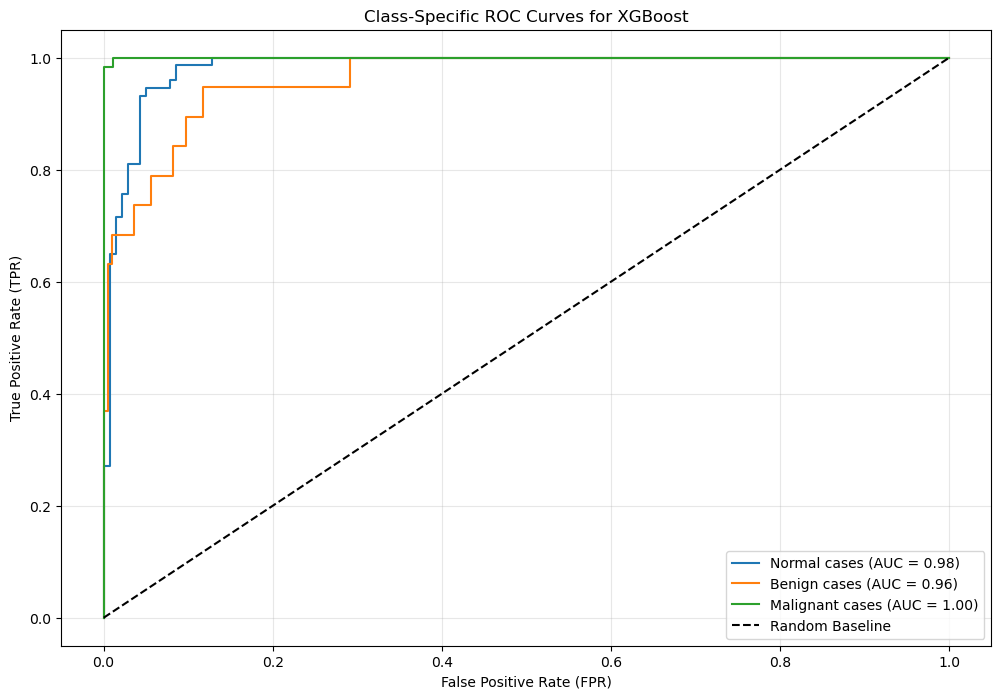

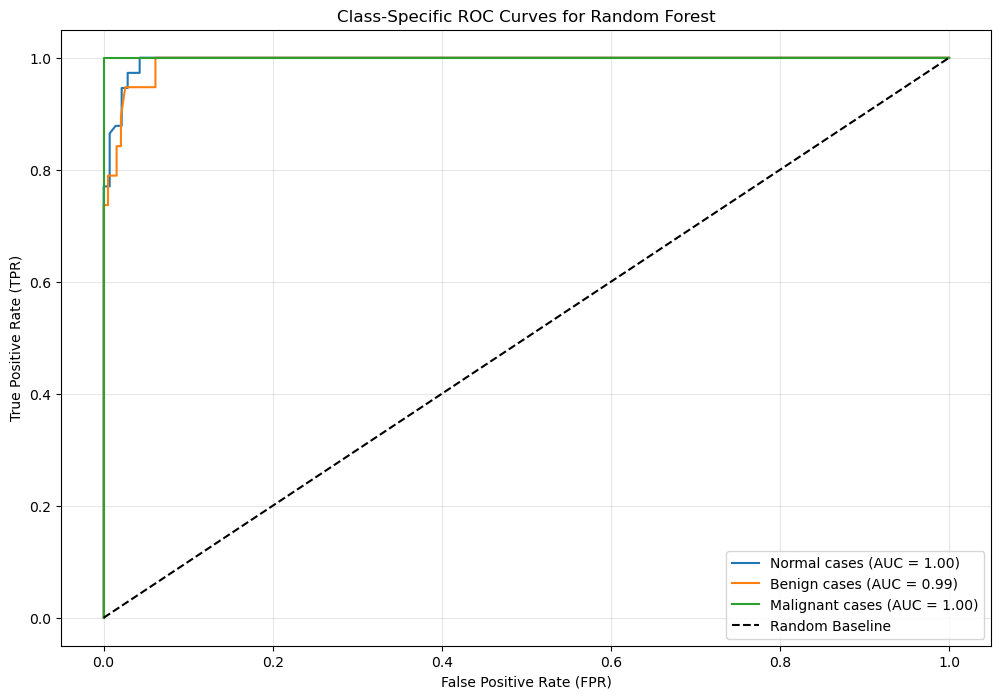

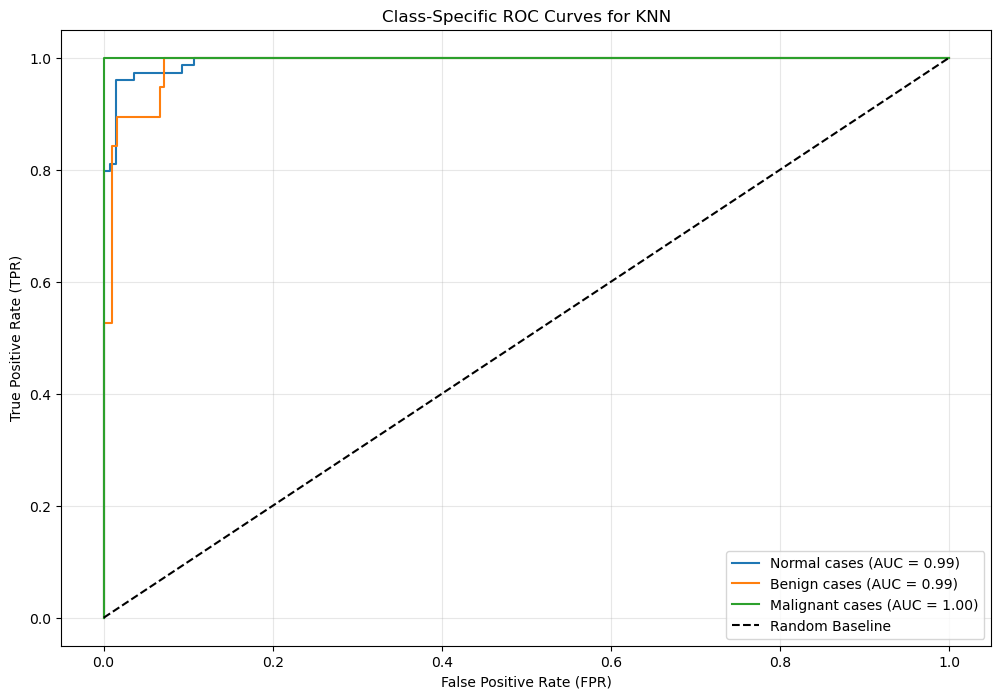

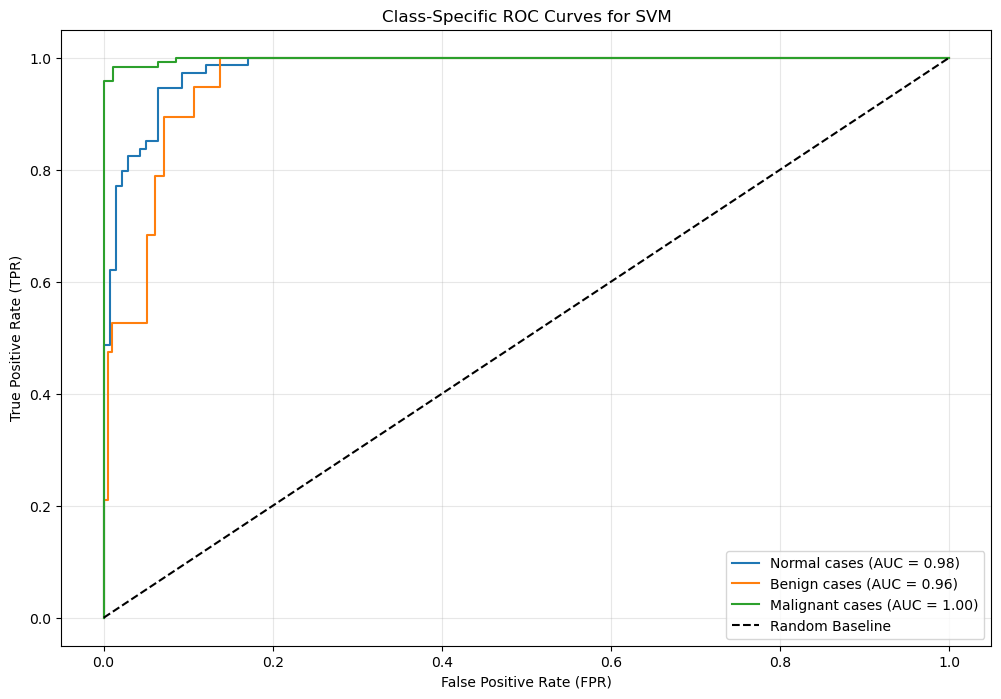

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Class names
classes = ['Normal cases', 'Benign cases', 'Malignant cases']
n_classes = len(classes)

# Binarize the labels
y_binarized = label_binarize(y_test, classes=list(range(n_classes)))

# Initialize models with best parameters
xgb_model = XGBClassifier(**best_xgb_params)
rf_model = RandomForestClassifier(**best_rf_params)
knn_model = KNeighborsClassifier(**best_knn_params)
svm_model = SVC(**best_svm_params, probability=True)

# Fit models
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predict probabilities
xgb_probs = xgb_model.predict_proba(X_test)
rf_probs = rf_model.predict_proba(X_test)
knn_probs = knn_model.predict_proba(X_test)
svm_probs = svm_model.predict_proba(X_test)

# List of models and their predictions
models = [
    ("XGBoost", xgb_probs),
    ("Random Forest", rf_probs),
    ("KNN", knn_probs),
    ("SVM", svm_probs)
]

# Generate class-specific ROC plots for each model
for model_name, probs in models:
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_binarized[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for each class
        plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")
    
    # Add labels, legend, and random baseline
    plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
    plt.title(f"Class-Specific ROC Curves for {model_name}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
